# 0. Libraries

In [15]:
pip install gym[box2d]
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install -U colabgymrender
from gym.wrappers.record_video import RecordVideo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [23]:
import gym
import numpy as np
from sklearn.linear_model import LogisticRegression
import sklearn.preprocessing as skpp

from random import randrange
from scipy.stats import bernoulli
import matplotlib.pyplot as plt
import math

#Tensor flow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from collections import deque
import random
from tqdm import tqdm

# 1. Data Acquisition

In [30]:
LunarEnv = gym.make(
    "LunarLander-v2",
    continuous= False,
    gravity = -10,
    enable_wind= False,
    wind_power= 15.0,
    turbulence_power= 1.5,
)

#uncomment to generate video 
LunarEnv = RecordVideo(LunarEnv, './video',  episode_trigger = lambda x: x % 100 == 0)

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/record_video.py:78: UserWarning: WARN: Overwriting existing videos at /content/video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


# 2. DQN

## Experience Replay Buffer

In [5]:
#Experience replay buffer using a queue
class ExRBuffer(object):
  def __init__(self, maxNumSamples):
    self.buffer = deque(maxlen=maxNumSamples)

  def add(self, sample): #sample has the tuple form (currentState, action, reward, nextState, terminal)
    self.buffer.append(sample)

  def accessFront(self):
    self.printFirst()
    return self.buffer[-1]

  def printFirst(self):
    print(self.buffer[0])

  def uniformSample(self, batchSize):
    currentStates = []
    actions = []
    rewards = []
    nextStates = []
    terminals = []

    for i in range(batchSize):
      #randomly sample the current buffer
      index = random.randint(0, self.length()-1)
      sample = self.buffer[index]
      currentStates.append(sample[0])
      actions.append(sample[1])
      rewards.append(sample[2])
      nextStates.append(sample[3])
      terminals.append(sample[4])

    return np.array(currentStates), np.array(actions), np.array(rewards, dtype=np.float32), np.array(nextStates), np.array(terminals, dtype=np.float32)
  
  def length(self):
    return len(self.buffer)

In [25]:
class MLP(tf.keras.Model):
  def __init__(self, initializer, layers, num_actions):
    super(MLP, self).__init__()

    self.denseLayers = []
    for l in layers:
      self.denseLayers.append(tf.keras.layers.Dense(l, activation="relu", kernel_initializer=initializer))
    self.denseLayers.append(tf.keras.layers.Dense(num_actions, kernel_initializer=initializer))

  def call(self, x):
    for dLayer in self.denseLayers:
      x = dLayer(x)
    return x

## DQN main functions

In [27]:
from scipy.special import j0
#beta is the learning rate for the state-value function
mse = tf.keras.losses.MeanSquaredError()
huber = tf.keras.losses.Huber()
class DQN(object):

  def __init__(self, bufferSize, rseed):
    self.bufferSize = bufferSize
    self.rseed = rseed
    

  def train(self, ENV, numActions, batchSize, layers, lr, endEps, epsDecay, discount, episodes=50, timeSteps = 32, main_train_steps = 4):
    
    self.lr = lr
    self.optimizer = tf.keras.optimizers.Adam(self.lr)
    self.eps = 1
    self.discount = discount
    self.numActions = numActions
    #Initialize replay memory D to capacity N
    self.replayBuffer = ExRBuffer(self.bufferSize)
    '''layers: the number of hidden nodes in each layer of the mlp model'''
    #Initialize policy params theta and state value weights w
    #set random seed
    np.random.seed(self.rseed)


    #Initialize action-value function Q with random weights h
    weightInitializer = tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None)


    inputSize =  8
    self.main_model = MLP(weightInitializer, layers, num_actions=self.numActions)

    #Initialize target action-value function Q using the same weights as the main model
    self.target_model = MLP(weightInitializer, layers, num_actions=self.numActions)
    self.main_model(np.array([np.zeros(inputSize)]))
    self.target_model(np.array([np.zeros(inputSize)]))
    self.target_model.set_weights(self.main_model.get_weights())

    transferSteps = 0
    allReturns = np.zeros(episodes)
    for j in tqdm(range(episodes)):
      #self.eps -= (1-endEps)/episodes 
      if(self.eps> endEps):
        self.eps *= epsDecay

      #Get the initial state
      currentState = ENV.reset()
      #Initialize episode return
      episodeReturn = 0
      currentStep = 0
      
      terminal = False
      while not terminal:
      
        #With probability e select a random action a_t
        currentAction = self.EpsGreedy(currentState)

        #Execute action a_t in emulator and observe reward r_t and next state s'
        nextState, reward, terminal, _ = ENV.step(currentAction)
        #Store transition st,at,rt,st+1 in the replay buffer
        sample = [currentState, currentAction, reward, nextState, terminal]
        self.replayBuffer.add(sample)

        #perform training
        if(self.replayBuffer.length() >= batchSize and transferSteps % main_train_steps == 0):
          currentStates, actions, rewards, nextStates, terminals = self.replayBuffer.uniformSample(batchSize)
          loss = self.trainStep(currentStates, actions, rewards, nextStates, terminals)

        transferSteps +=1

        #transfer the weights ever C steps
        if(transferSteps>=timeSteps):
          self.target_model.set_weights(self.main_model.get_weights())
          transferSteps = 0
        
        currentState = nextState
        currentStep += 1
        episodeReturn += reward 

      #print("Episode return" + str(episodeReturn))
      #print("Number of steps" + str(currentStep))
      #print("Current eps = " + str(self.eps))

      allReturns[j] = episodeReturn
    return allReturns

  '''
  def trainStep1(self, batchSize):
    #sample from the replay buffer
    currentStates, actions, rewards, nextStates, terminals = self.replayBuffer.uniformSample(batchSize)

    nextQvals = self.target_model(nextStates)
    maxNextQvals = tf.reduce_max(nextQvals, axis = 1)
    y = rewards + (1-terminals) * self.discount * maxNextQvals
    Qvals = self.main_model(currentStates)
    action_masks = tf.one_hot(actions, self.numActions)
    maskedQvals = action_masks * Qvals
    
    self.main_model.fit(currentStates, maskedQvals)
  '''

  @tf.function
  def trainStep(self, states, actions, rewards, next_states, dones):
    """Perform a training iteration on a batch of data sampled from the experience
    replay buffer."""
    # Calculate targets.
    next_qs = self.target_model(next_states)
    max_next_qs = tf.reduce_max(next_qs, axis=-1)
    target = rewards + (1. - dones) * self.discount * max_next_qs
    with tf.GradientTape() as tape:
      qs = self.main_model(states)
      action_masks = tf.one_hot(actions, self.numActions)
      masked_qs = tf.reduce_sum(action_masks * qs, axis=-1)
      loss = huber(target, masked_qs)
    grads = tape.gradient(loss, self.main_model.trainable_variables)
    #clipped_gradients = [tf.clip_by_norm(grad, 10) for grad in grads]
    self.optimizer.apply_gradients(zip(grads, self.main_model.trainable_variables))
    return loss

    '''
    Initialize sequence s1~f g x1 and preprocessed sequence w1~wð Þ s1
      For t 5 1,T do
        With probability e select a random action at
        otherwise select at~argmaxaQ wð Þ st ð Þ ,a; h
        Execute action at in emulator and observe reward rt and image xt 1 1
        Set stz1~st,at,xtz1 and preprocess wtz1~wð Þ stz1
        Store transition wt,at,rt,wtz1
            in D
        Sample random minibatch of transitions wj,aj,rj,wjz1

        
 from D
        Set yj~ rj if episode terminates at step jz1
        rjzc maxa0 Q^ wjz1,a0
        ; h{ 
        
 otherwise (
        Perform a gradient descent step on yj{Q wj,aj; h

        
 
        
 2
        with respect to the
        network parameters h
        Every C steps reset Q^~Q
      End For
    End For
    '''

  def linearModel(self, inputSize, layers, initializer):

    '''
    inputSize: the size of the the states
    numActions: the number of possible actions
    layers: the number of nodes for each hidden state
    initializer: how to initialize the weights of the hidden layers
    '''
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=(inputSize,)))

    for i in layers:
      model.add(tf.keras.layers.Dense(i, activation="relu", kernel_initializer=initializer))

    model.add(tf.keras.layers.Dense(self.numActions, kernel_initializer=initializer))
    model.compile(optimizer=tf.keras.optimizers.Adam(self.lr), loss="mse")
    return model


  #returns the epsilon greedy eaction
  def EpsGreedy(self, state):
    #epsilon choice
    if bernoulli.rvs(self.eps) > 0 :
      return random.randint(0, self.numActions-1)

    #greedy choice
    else:
      return np.argmax(self.main_model(np.array([state])))

## Testing

In [28]:
# Main video uses the following video
dqn = DQN(300000, 123)
x1 = dqn.train(LunarEnv, 4, 128, [64,64,64], 0.001, 0.01, 0.99, 0.99, episodes = 501, timeSteps=1000, main_train_steps = 4)

/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer RandomUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(
  0%|          | 0/500 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment LunarLander-v2 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/p

In [7]:
def plotAlphas(alphas, episodes, discount):
  results = np.zeros((len(alphas), episodes))

  index = 0
  for a in alphas: 
    dqn = DQN(300000, 123)
    results[index] = dqn.train(LunarEnv, 4, 128, [64,64,64], a, 0.01, 0.99, discount, episodes = episodes, timeSteps=1000, main_train_steps = 4)
    lab = str(a)
    plt.plot(results[index], label= lab)
    index += 1

  plt.legend(loc = 'lower right', title='Alpha')
  plt.title("Varying Alphas Performance; Discount = " + str(discount))
  plt.xlabel("Episode")
  plt.ylabel("Return")
  return results

/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer RandomUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(
100%|██████████| 1000/1000 [1:02:23<00:00,  3.74s/it]


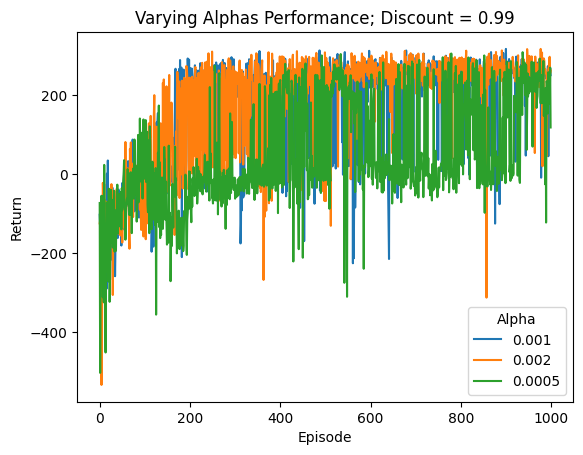

In [8]:
results = plotAlphas([0.001, 0.002, 0.0005], 1000,  0.99)

In [ ]:
def plotDiscount(discounts, episodes, alpha):
  results = np.zeros((len(discounts), episodes))

  index = 0
  for d in discounts: 
    dqn = DQN(300000, 123)
    results[index] = dqn.train(LunarEnv, 4, 128, [64,64,64], alpha, 0.01, 0.995, d, episodes = episodes, timeSteps=1000, main_train_steps = 4)
    lab = str(d)
    plt.plot(results[index], label= lab)
    index += 1

  plt.legend(loc = 'lower right', title='Discount')
  plt.title("Varying Discount Performance; Alpha = "+ str(alpha))
  plt.xlabel("Episode")
  plt.ylabel("Return")
  return results

/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer RandomUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(
100%|██████████| 800/800 [39:42<00:00,  2.98s/it]


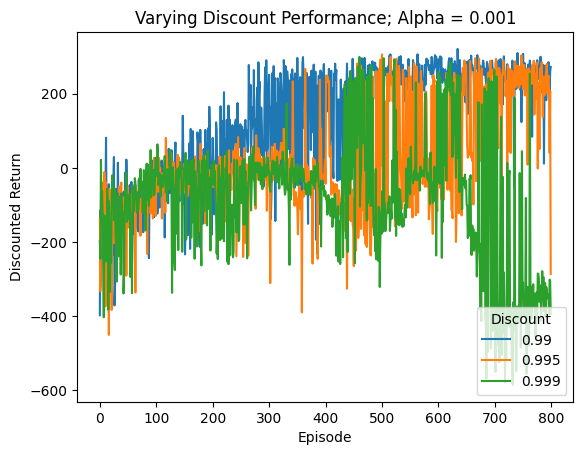

In [ ]:
resultsDisc = plotDiscount([0.99, 0.995, 0.999], 800,  0.001)

In [ ]:
def plotEps(eps, episodes, alpha):
  results = np.zeros((len(eps), episodes))

  index = 0
  for e in eps: 
    dqn = DQN(300000, 123)
    results[index] = dqn.train(LunarEnv, 4, 128, [64,64,64], alpha, 0.01, e, 0.99, episodes = episodes, timeSteps=1000, main_train_steps = 4)
    lab = str(e)
    plt.plot(results[index], label= lab)
    index += 1

  plt.legend(loc = 'lower right', title='Epsilon')
  plt.title("Varying Epsilon scheduling Performance; Alpha = "+ str(alpha))
  plt.xlabel("Episode")
  plt.ylabel("Return")
  return results

100%|██████████| 800/800 [02:46<00:00,  4.79it/s]


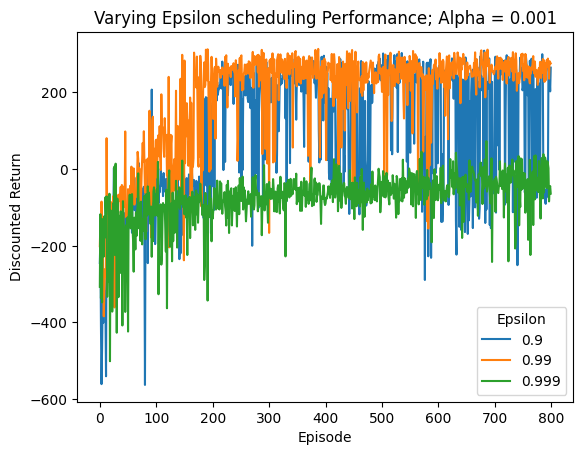

In [ ]:
resultsEps = plotEps([0.9, 0.99, 0.999], 800,  0.001)